# Final project

### ** Part 1: Read and parse the initial dataset **

In [0]:
# import findspark
# findspark.init()

# import pyspark
# sc = pyspark.SparkContext(appName="myAppName")

# Import the NumPy module
import numpy as np

from pyspark.sql import SparkSession

from pyspark.mllib.regression import LabeledPoint
import numpy as np



Load and check the data

In [0]:
import os.path
baseDir = os.path.join('.')
input1 = os.path.join('/FileStore/tables/deerfoot.csv')
input2 = os.path.join('/FileStore/tables/eng_daily_01012013_12312013-5.csv')
input3 = os.path.join('/FileStore/tables/eng_daily_01012014_12312014-2.csv')
file1 = os.path.join(baseDir, input1)
file2 = os.path.join(baseDir, input2)
file3 = os.path.join(baseDir, input3)

deerfootRDD = sc.textFile(file1, 8)
weather13RDD = sc.textFile(file2,8)
weather14RDD = sc.textFile(file3,8)

Preprocessing RDDs - extracting desired fields from commute time data

In [0]:
# take date as key, commute quality total accident number as value
def commuteExtractFields(deerfootRDDRecord):
    commuteList = deerfootRDDRecord.split(',')
    commuteTime=commuteList[2:21]
    sumTime=0
    for time in commuteTime:
        sumTime+=int(time)
    meanCommuteTime=sumTime/len(commuteTime)
    quality="0"
    if (meanCommuteTime<37.811):
        quality="1"
    

    return (commuteList[0],(quality, commuteList[-1]))
deerfootPairRDD = deerfootRDD.map(commuteExtractFields)
print(deerfootPairRDD.take(8))

[('21/09/2013', ('1', '2')), ('22/09/2013', ('1', '3')), ('23/09/2013', ('0', '2')), ('24/09/2013', ('0', '5')), ('25/09/2013', ('0', '5')), ('26/09/2013', ('0', '13')), ('27/09/2013', ('0', '6')), ('28/09/2013', ('1', '1'))]


Preprocessing RDDs - extracting desired fields from weather data

In [0]:
# Skips lines with metadata and label information
def weatherExtractFields(weatherRDDRecord):
    weatherList = weatherRDDRecord.split(',')
    if u'2013' in weatherList[0] or u'2014' in weatherList[0]:
        return True 
    else:
        return False

filtered13RDD = weather13RDD.filter(weatherExtractFields)
filtered14RDD = weather14RDD.filter(weatherExtractFields)
print(filtered13RDD.take(5))
print(filtered14RDD.take(5))

['"2013-01-01","2013","01","01","�","1.2","","-8.9","","-3.9","","21.9","","0.0","","0.0","T","0.0","","0.0","T","4","","33","","48",""', '"2013-01-02","2013","01","02","�","5.8","","-10.9","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","3","","29","","41",""', '"2013-01-03","2013","01","03","�","8.8","","-8.8","","0.0","","18.0","","0.0","","0.0","","0.0","","0.0","","2","","28","","52",""', '"2013-01-04","2013","01","04","�","2.9","","-11.2","","-4.2","","22.2","","0.0","","0.0","","0.0","","0.0","","2","","26","","63",""', '"2013-01-05","2013","01","05","�","4.8","","-10.0","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","1","","27","","41",""']
['"2014-01-01","2014","01","01","�","-0.6","","-9.7","","-5.2","","23.2","","0.0","","0.0","","1.0","","0.8","","9","","","","<31",""', '"2014-01-02","2014","01","02","�","8.5","","-10.0","","-0.8","","18.8","","0.0","","0.0","","0.0","","0.0","","11","","27","","52",""', '"2014-01-03","2014","01","03","�","3.0","","-1

Preprocessing RDDs - Fixing date format inconsistency

In [0]:
# fix date form
def fixDate(weatherRDDRecord):
    extractList = weatherRDDRecord.split(',')
    year,month,day = extractList[0].split('-')
    print(year)
    return (day[:-1]+'/'+month+'/'+year[1:], ', '.join(extractList[1:]))


fixed13RDD = filtered13RDD.map(fixDate)
fixed14RDD = filtered14RDD.map(fixDate)
print(fixed13RDD.take(2))
print(fixed14RDD.take(2))

[('01/01/2013', '"2013", "01", "01", "�", "1.2", "", "-8.9", "", "-3.9", "", "21.9", "", "0.0", "", "0.0", "T", "0.0", "", "0.0", "T", "4", "", "33", "", "48", ""'), ('02/01/2013', '"2013", "01", "02", "�", "5.8", "", "-10.9", "", "-2.6", "", "20.6", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "3", "", "29", "", "41", ""')]
[('01/01/2014', '"2014", "01", "01", "�", "-0.6", "", "-9.7", "", "-5.2", "", "23.2", "", "0.0", "", "0.0", "", "1.0", "", "0.8", "", "9", "", "", "", "<31", ""'), ('02/01/2014', '"2014", "01", "02", "�", "8.5", "", "-10.0", "", "-0.8", "", "18.8", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "11", "", "27", "", "52", ""')]


Extracting the desired days from weather data

In [0]:
# take common date
def extractDates(weatherRDDRecord):
    value = weatherRDDRecord[1]
    weatherFields = value.split(",")
    valid13Months = [u'"09"',u'"10"',u'"11"',u'"12"']
    valid13Sept = [u'"21"',u'"22"',u'"23"',u'"24"',u'"25"',u'"26"',u'"27"',u'"28"',u'"29"',u'"30"']
    valid14Months=[u'"01"',u'"02"',u'"03"',u'"04"']
    valid14Apr=[u'"01"',u'"02"',u'"03"',u'"04"',u'"05"',u'"06"',u'"07"',u'"08"',u'"09"',u'"10"']
    if weatherFields[0]==u'"2013"':      
        if weatherFields[1].strip() in valid13Months:
            if weatherFields[1].strip()==u'"09"':
                if weatherFields[2].strip() in valid13Sept:
                    return True
                else:
                    return False
            else:
                return True
        else:
            return False    
    else:
        if weatherFields[1].strip() in valid14Months:
            if weatherFields[1].strip()==u'"04"':
                if weatherFields[2].strip() in valid14Apr:
                    return True
                else:
                    return False
            else:
                return True
        else:
            return False

aggregateWeatherRDD = fixed13RDD.union(fixed14RDD)  
print(aggregateWeatherRDD.count())
desiredWeatherRDD = aggregateWeatherRDD.filter(extractDates)
print(desiredWeatherRDD.count())

730
202


Merging commute time and weather data

In [0]:
combinedPairRDD = deerfootPairRDD.join(desiredWeatherRDD)
print(combinedPairRDD.count())
print(combinedPairRDD.take(5))

202
[('30/09/2013', (('0', '7'), '"2013", "09", "30", "�", "14.3", "", "2.2", "", "8.3", "", "9.7", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "", "", "26", "", "72", ""')), ('11/11/2013', (('1', '0'), '"2013", "11", "11", "�", "1.6", "", "-13.8", "", "-6.1", "", "24.1", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "3", "", "", "", "<31", ""')), ('05/12/2013', (('0', '8'), '"2013", "12", "05", "�", "-19.8", "", "-26.2", "", "-23.0", "", "41.0", "", "0.0", "", "0.0", "", "0.4", "", "0.2", "", "13", "", "33", "", "33", ""')), ('25/12/2013', (('1', '0'), '"2013", "12", "25", "�", "6.5", "", "-10.1", "", "-1.8", "", "19.8", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "12", "", "26", "", "63", ""')), ('07/01/2014', (('0', '6'), '"2014", "01", "07", "�", "-3.0", "", "-9.9", "", "-6.5", "", "24.5", "", "0.0", "", "0.0", "", "0.0", "T", "0.0", "T", "8", "", "18", "", "32", ""'))]


Filter out weekends and unwanted weather fields to produce fina data

In [0]:
def extractRegressionData(combinedPairRDDRecord):
#    Outputs a string record with the format "quality, total number of accidents, Mean temperature, Total rain, Total snow, snow on ground"
    
    value = combinedPairRDDRecord[1]
    weatherFieldList = value[1].split(",")
    
    snoG = weatherFieldList[20]
    if snoG.strip()==u'""':
        snoG="0"
    else:
        snoG=snoG[2:-1]
        
    meanTemp = weatherFieldList[8]
    if meanTemp.strip()==u'""':
        meanTemp='0'
        
    totalRain = weatherFieldList[14]
    if totalRain.strip()==u'""':
        totalRain='0'
        
    totalSnow = weatherFieldList[16]
    if totalSnow.strip()==u'""':
        totalSnow='0'
    
        
#     quality, total number of accidents, Mean temperature, Total rain, Total snow, snow on ground
    returnRecord = str(value[0][0])+","+str(value[0][1])+","+meanTemp+","+totalRain+","+totalSnow+","+snoG
    return returnRecord

modelDataRDD = combinedPairRDD.map(extractRegressionData)
print(modelDataRDD.take(5))

['0,7, "8.3", "0.0", "0.0",0', '1,0, "-6.1", "0.0", "0.0",3', '0,8, "-23.0", "0.0", "0.4",13', '1,0, "-1.8", "0.0", "0.0",12', '0,6, "-6.5", "0.0", "0.0",8']


Using labeled point

In [0]:
# Converts a comma separated unicode string into a `LabeledPoint`.
def parsePoint(line):
    label_features = line.replace('"', "").split(',')
    
    ret_val = LabeledPoint(label_features[0],label_features[1:])
    return ret_val

parsedSamplePoints = modelDataRDD.map(parsePoint)
firstPoint = parsedSamplePoints.take(5)
firstPointFeatures =firstPoint[0].features 
firstPointLabel = firstPoint[0].label
print (firstPointFeatures, firstPointLabel)
d = len(firstPointFeatures)
print(d)

[7.0,8.3,0.0,0.0,0.0] 0.0
5


Preprocessing

In [0]:
# normalized data
def normalizeFeatures(lp):
    normalizedFeatures = list()
    for i in range(0,len(lp.features)):
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        normalizedFeatures.insert(i,feature)
    return LabeledPoint(lp.label, normalizedFeatures)

def normalizedRDD(nonNormalizedRDD): 
    meanList = list()
    stdevList = list()
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(0,numFeatures):
        featureRDD = nonNormalizedRDD.map(lambda lp: lp.features[i])
        featureMean = featureRDD.mean()
        featureStdev = featureRDD.stdev()
        meanList.insert(i,featureMean)
        stdevList.insert(i,featureStdev)
    global broadcastMean 
    broadcastMean = sc.broadcast(meanList)
    global broadcastStdev 
    broadcastStdev = sc.broadcast(stdevList)
    returnRDD = nonNormalizedRDD.map(normalizeFeatures)
    return returnRDD

normalizedData = normalizedRDD(parsedSamplePoints)
print(normalizedData.take(5))

[LabeledPoint(0.0, [0.9238885865742724,1.28782637375744,-0.11003237823565358,-0.35209551829917046,-0.6859736893870207]), LabeledPoint(1.0, [-1.2497860580447315,-0.2506472210454847,-0.11003237823565358,-0.35209551829917046,-0.12345669917249483]), LabeledPoint(0.0, [1.2344135358055588,-2.056216926057251,-0.11003237823565358,-0.16406301414468946,1.7515999348759248]), LabeledPoint(1.0, [-1.2497860580447315,0.20875808851372193,-0.11003237823565358,-0.35209551829917046,1.5640942714710828]), LabeledPoint(0.0, [0.6133636373429862,-0.2933825986788993,-0.11003237823565358,-0.35209551829917046,0.8140716178517151])]


Split Dataset

In [0]:
# split the data to 70% train and 30% test
weights = [.7, .3]
seed = 42
parsedTrainData, parsedValData = parsedSamplePoints.randomSplit(weights,seed)
labels = parsedValData.map(lambda x: x.label).collect()


parsedNmTrainData, parsedNmValData = normalizedData.randomSplit(weights,seed)

Linear Support Vector Machines (SVMs)

In [0]:
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [0]:
# Train the model with train data
SVM = SVMWithSGD.train(parsedTrainData)

In [0]:
#Before normalized

# yPre=predict the prediction base test data
predictionsSVM = SVM.predict(parsedValData.map(lambda x: x.features)).collect()
rmseSVM = np.sqrt(np.mean((np.array(predictionsSVM)-np.array(labels))**2))
# create confusion Matrix
predictionAndLabelsSVM = parsedValData.map(lambda lp: (float(SVM.predict(lp.features)), lp.label))
metricsSVM = MulticlassMetrics(predictionAndLabelsSVM)

# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsSVM.confusionMatrix().toArray())
print("\nRMSE score= ",rmseSVM)
print("Accuracy scores = %s" % metricsSVM.accuracy)
print("Precision = %s" %  metricsSVM.weightedPrecision)
print("Recall = %s" % metricsSVM.weightedRecall)
print("F1 Score = %s" % metricsSVM.weightedFMeasure())

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Summary Stats: 

Confusion Matrix:
[[29.  3.]
 [24. 11.]]

RMSE score=  0.6348110542727384
Accuracy scores = 0.5970149253731343
Precision = 0.6717825964517037
Recall = 0.5970149253731343
F1 Score = 0.5604414900288472


In [0]:
SVM_Nm = SVMWithSGD.train(parsedNmTrainData)

In [0]:
# SVM after nomalized
predictionsSVM_Nm = SVM_Nm.predict(parsedNmValData.map(lambda x: x.features)).collect()
rmseSVM_Nm = np.sqrt(np.mean((np.array(predictionsSVM_Nm)-np.array(labels))**2))
# create confusion Matrix
predictionAndLabelsSVM_Nm = parsedNmValData.map(lambda lp: (float(SVM_Nm.predict(lp.features)), lp.label))
metricsSVM_Nm = MulticlassMetrics(predictionAndLabelsSVM_Nm)

print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsSVM_Nm.confusionMatrix().toArray())
print("\nRMSE score:", rmseSVM_Nm)
print("Accuracy scores:",metricsSVM_Nm.accuracy)
print("Precision = %s" % metricsSVM_Nm.weightedPrecision)
print("Recall = %s" % metricsSVM_Nm.weightedRecall)
print("F1 Score = %s" % metricsSVM_Nm.weightedFMeasure())

Summary Stats: 

Confusion Matrix:
[[22. 10.]
 [ 8. 27.]]

RMSE score: 0.5183210553488161
Accuracy scores: 0.7313432835820896
Precision = 0.7314508538389135
Recall = 0.7313432835820896
F1 Score = 0.7307414540202215


Logistic Regression

In [0]:
from pyspark.mllib.classification import LogisticRegressionWithSGD


In [0]:
# train the LG model with Raw data
LR = LogisticRegressionWithSGD.train(parsedTrainData)

/databricks/spark/python/pyspark/mllib/classification.py:325: FutureWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  warnings.warn(


In [0]:
# LG before normalized 
predictionsLR = LR.predict(parsedValData.map(lambda x: x.features)).collect()
rmseLR = np.sqrt(np.mean((np.array(predictionsLR)-np.array(labels))**2))
# create confusion Matrix
predictionAndLabelsLR = parsedValData.map(lambda lp: (float(LR.predict(lp.features)), lp.label))
metricsLR = MulticlassMetrics(predictionAndLabelsLR)


# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsLR.confusionMatrix().toArray())
print("\nRMSE score= ",rmseLR)
print("Accuracy scores = %s" % metricsLR.accuracy)
print("Precision = %s" %  metricsLR.weightedPrecision)
print("Recall = %s" % metricsLR.weightedRecall)
print("F1 Score = %s" % metricsLR.weightedFMeasure())

Summary Stats: 

Confusion Matrix:
[[30.  2.]
 [28.  7.]]

RMSE score=  0.6691496051182058
Accuracy scores = 0.5522388059701493
Precision = 0.653342482987362
Recall = 0.5522388059701493
F1 Score = 0.4846223428312981


In [0]:
# Train LG model with normalized data
LR_Nm = LogisticRegressionWithSGD.train(parsedNmTrainData)

In [0]:
# LG model after Normalized
predictionsLR_Nm = SVM_Nm.predict(parsedNmValData.map(lambda x: x.features)).collect()
rmseLR_Nm = np.sqrt(np.mean((np.array(predictionsLR_Nm)-np.array(labels))**2))
# create confusion Matrix
predictionAndLabelsLR_Nm = parsedNmValData.map(lambda lp: (float(LR_Nm.predict(lp.features)), lp.label))
metricsLR_Nm = MulticlassMetrics(predictionAndLabelsLR_Nm)

# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsLR_Nm.confusionMatrix().toArray())
print("\nRMSE score= ",rmseLR_Nm)
print("Accuracy scores = %s" % metricsLR_Nm.accuracy)
print("Precision = %s" %  metricsLR_Nm.weightedPrecision)
print("Recall = %s" % metricsLR_Nm.weightedRecall)
print("F1 Score = %s" % metricsLR_Nm.weightedFMeasure())

Summary Stats: 

Confusion Matrix:
[[22. 10.]
 [ 7. 28.]]

RMSE score=  0.5183210553488161
Accuracy scores = 0.746268656716418
Precision = 0.7472438172115827
Recall = 0.7462686567164178
F1 Score = 0.7452430191284762


Decision Tree

In [0]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [0]:
# DT with raw data
DT = DecisionTree.trainClassifier(parsedTrainData,2,{})

In [0]:
# DT with nomarlized data
DT_Nm = DecisionTree.trainClassifier(parsedNmTrainData,2,{})

In [0]:
# DT with raw data
#  get label predict
predictionsDT = DT.predict(parsedValData.map(lambda x: x.features)).collect()
#  calculate rmse score
rmseDT = np.sqrt(np.mean((np.array(predictionsDT)-np.array(labels))**2))

predictionsdt = DT.predict(parsedValData.map(lambda x: x.features))
predictionAndLabelsDT = predictionsdt.zip(parsedValData.map(lambda lp: lp.label))
# get multiclass matirx
metricsDT = MulticlassMetrics(predictionAndLabelsDT)

# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsDT.confusionMatrix().toArray())
print("\nRMSE score= ",rmseDT)
print("Accuracy scores = %s" % metricsDT.accuracy)
print("Precision = %s" %  metricsDT.weightedPrecision)
print("Recall = %s" % metricsDT.weightedRecall)
print("F1 Score = %s" % metricsDT.weightedFMeasure())

Summary Stats: 

Confusion Matrix:
[[25.  7.]
 [11. 24.]]

RMSE score=  0.5183210553488161
Accuracy scores = 0.7313432835820896
Precision = 0.7361044241159793
Recall = 0.7313432835820896
F1 Score = 0.7311038390933035


In [0]:
# DT with normalized data
#  get label predict
predictionsDT_Nm = DT_Nm.predict(parsedNmValData.map(lambda x: x.features)).collect()
#  calculate rmse score
rmseDT_Nm = np.sqrt(np.mean((np.array(predictionsDT_Nm)-np.array(labels))**2))

predictionsdt_Nm = DT_Nm.predict(parsedNmValData.map(lambda x: x.features))
predictionAndLabelsDT_Nm = predictionsdt_Nm.zip(parsedNmValData.map(lambda lp: lp.label))
# get multiclass matirx
metricsDT_Nm = MulticlassMetrics(predictionAndLabelsDT_Nm)

# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsDT_Nm.confusionMatrix().toArray())
print("\nRMSE score= ",rmseDT_Nm)
print("Accuracy scores = %s" % metricsDT_Nm.accuracy)
print("Precision = %s" %  metricsDT_Nm.weightedPrecision)
print("Recall = %s" % metricsDT_Nm.weightedRecall)
print("F1 Score = %s" % metricsDT_Nm.weightedFMeasure())

Summary Stats: 

Confusion Matrix:
[[25.  7.]
 [11. 24.]]

RMSE score=  0.5183210553488161
Accuracy scores = 0.7313432835820896
Precision = 0.7361044241159793
Recall = 0.7313432835820896
F1 Score = 0.7311038390933035


Use loop find the best parameter combination

In [0]:
# LR_Nm = LogisticRegressionWithSGD()
# regParam=[0, 0.1,0.01,0.001]
# regTypestr = ['l1','l2',None]
# intercept=[True,False]
# validateData=[True,False]
# maxvalue=0
# maxName=""



# scores={}

# for i in regParam:
#     for j in regTypestr:
#         for q in intercept:
#             for w in validateData:
#                 LR_Nm = LogisticRegressionWithSGD.train(data = parsedNmTrainData, regParam=i, regType=j,intercept=q, validateData=w)
#                 p_l_LR_Nm = parsedNmValData.map(lambda lp: (float(LR_Nm.predict(lp.features)), lp.label))
#                 metricsLR_Nm = MulticlassMetrics(p_l_LR_Nm)
#                 if j== None:
#                     regSet = str(i) + "," + "None"+","+str(q)+","+str(w)

#                 else:
#                     regSet = str(i) + "," + j+","+str(q)+","+str(w)
                
#                 if( metricsLR_Nm.accuracy>maxvalue):
#                     maxvalue=metricsLR_Nm.accuracy
#                     maxName=regSet

# #                 scores.update({regSet: metricsLR_Nm.accuracy})
                    
                        
# print("maxValue:",maxvalue)
# print("maxName:",maxName)
# # scores
        

maxValue: 0.746268656716418
maxName: 0,l1,False,True


Final Model by using Logistic Regression with Nomalized Data

In [0]:
LR_fin = LogisticRegressionWithSGD.train(parsedNmTrainData,
        iterations=100,
        step= 1.5,
        miniBatchFraction= 1.0,
        initialWeights = [1.4,0.1,0.2,0.2,1.4],
        regParam = 0.1,
        regType= "l1",
        intercept = False,
        validateData= True,
        convergenceTol= 0.001,)
predictionsLR_fin = LR_fin.predict(parsedNmValData.map(lambda x: x.features)).collect()
rmseLR_fin = np.sqrt(np.mean((np.array(predictionsLR_Nm)-np.array(labels))**2))
predictionAndLabelsLR_fin = parsedNmValData.map(lambda lp: (float(LR_fin.predict(lp.features)), lp.label))
metricsLR_fin = MulticlassMetrics(predictionAndLabelsLR_fin)

# Overall statistics
print("Summary Stats: \n")
print("Confusion Matrix:")
print(metricsLR_fin.confusionMatrix().toArray())
print("\nRMSE score= ",rmseLR_fin)
print("Accuracy scores = %s" % metricsLR_fin.accuracy)
print("Precision = %s" %  metricsLR_fin.weightedPrecision)
print("Recall = %s" % metricsLR_fin.weightedRecall)
print("F1 Score = %s" % metricsLR_fin.weightedFMeasure())
# 0. 746268656716418 

Summary Stats: 

Confusion Matrix:
[[22. 10.]
 [ 7. 28.]]

RMSE score=  0.5183210553488161
Accuracy scores = 0.746268656716418
Precision = 0.7472438172115827
Recall = 0.7462686567164178
F1 Score = 0.7452430191284762


Visualization

predict:  [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
True:  [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


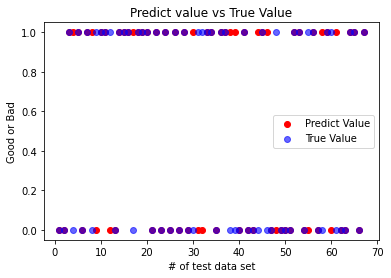

<Figure size 4800x3200 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

# draw the graph of the result
ypre=predictionsLR_fin
ytrue=labels

print("predict: ",ypre)
print("True: ",ytrue)
length=len(ypre)
x=[]
for i in range(1,length+1):
    x.append(i)

print(x)

plt.scatter(x,ypre,color='red',label='Predict Value')
plt.scatter(x,ytrue,color='blue',label='True Value', alpha=0.6)
plt.xlabel("# of test data set")
plt.ylabel("Good or Bad")
plt.title("Predict value vs True Value")
plt.legend()
plt.figure(dpi=800)
plt.show()